# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd
import seaborn as sb

### Откройте файл с данными и изучите общую информацию. 

In [2]:
try:
   data = pd.read_csv('datasets/real_estate_data.csv', sep='\t')
except:
   data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
pd.set_option('display.max_columns', None)
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

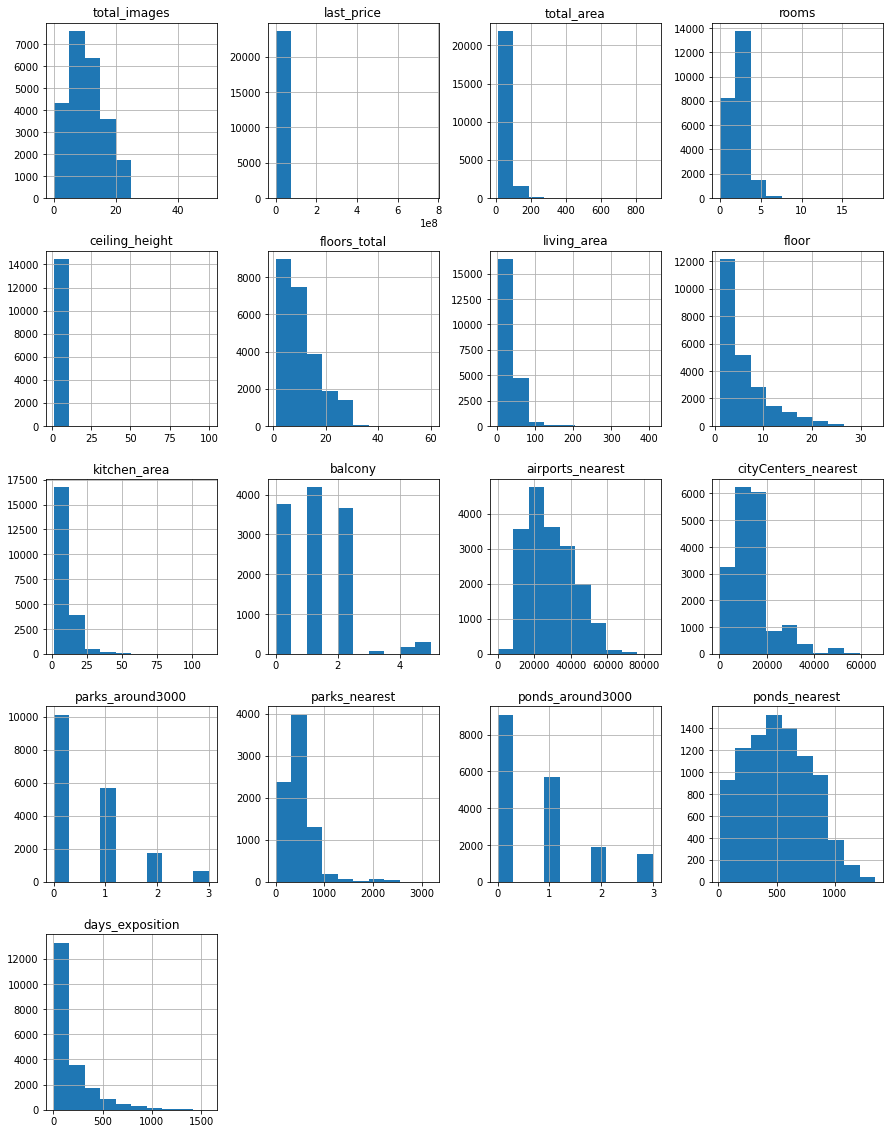

In [4]:
data.hist(figsize=(15, 20));

### Наблюдения по общей информации:
1. `floors_total` мало пропусков, возможно это предложения в отдноэтажных домах, нужен анализ
2. `ceiling_height` - много пропусков Подумать как заполнить: средним по дому, району, количеству комнат, площади?
3. `living_area` мало пропусков, возможно стоит заполнить медианным значение по квартирам такого же метража
4. `is_apartment` почти не заполнено, скорей всего там стоит "да" вместо True , сконвертировать в булево
5. `kitchen_area` аналогично `living_area`
6. `balcony` - предположим, что где не заполнено, значит балкон отсутствует, выставим в 0 и поменяем тип на int
7. `locality_name` совсем непонятно что с пропусками, будем изучать
8. Картографические данные с пропусками, возможно значат что рядом ничего нет 
9. `days_exposition` - возможно пропуски по тем лотам, которые продались в тот же день

Всего несколько гистограмм показывают нормальное распределение, остальные испорчены выбросами, которые надо не забыть удалить перед анализом


### Предобработка данных

#### Анализ зависимостей

<AxesSubplot:>

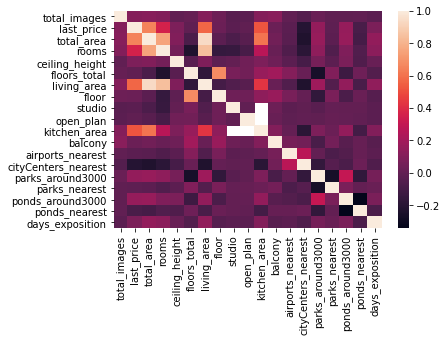

In [5]:

sb.heatmap(data.corr())

In [6]:
data.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_images,1.000000,0.104473,0.115352,0.099288,-0.001987,0.010427,0.104780,0.031340,-0.029303,-0.024407,0.104756,0.121693,-0.002298,-0.047666,0.021120,-0.008347,-0.011553,-0.003034,-0.026657
last_price,0.104473,1.000000,0.653675,0.363343,0.085430,-0.006984,0.566492,0.026576,-0.025362,-0.008802,0.519869,0.029646,-0.026239,-0.206747,0.151058,-0.016414,0.159996,-0.084809,0.081146
total_area,0.115352,0.653675,1.000000,0.758344,0.095490,-0.075774,0.939537,-0.024754,-0.072653,-0.034885,0.609121,0.047937,-0.030753,-0.231446,0.164689,-0.021497,0.162346,-0.097969,0.149675
rooms,0.099288,0.363343,0.758344,1.000000,0.054457,-0.228215,0.845977,-0.150862,-0.147286,-0.087500,0.269945,0.017991,-0.061199,-0.184864,0.137257,-0.054549,0.092693,-0.057689,0.126961
ceiling_height,-0.001987,0.085430,0.095490,0.054457,1.000000,-0.028732,0.090650,-0.011798,0.001674,0.042777,0.087641,0.040523,-0.023947,-0.091689,0.065915,-0.019167,0.078209,-0.059090,0.019091
floors_total,0.010427,-0.006984,-0.075774,-0.228215,-0.028732,1.000000,-0.169311,0.678059,0.070151,0.050791,0.163944,0.194065,0.108288,0.019774,-0.252833,0.097527,-0.122735,0.038864,-0.052234
living_area,0.104780,0.566492,0.939537,0.845977,0.090650,-0.169311,1.000000,-0.097210,-0.056231,-0.033711,0.428674,0.018849,-0.057912,-0.231368,0.184453,-0.050167,0.148933,-0.081674,0.142454
floor,0.031340,0.026576,-0.024754,-0.150862,-0.011798,0.678059,-0.097210,1.000000,0.036940,0.035824,0.135531,0.168773,0.071597,0.009084,-0.163784,0.073045,-0.076312,0.024850,-0.039463
studio,-0.029303,-0.025362,-0.072653,-0.147286,0.001674,0.070151,-0.056231,0.036940,1.000000,-0.004235,NaN,0.031455,-0.021876,-0.007029,-0.030202,0.009134,0.000939,0.002606,-0.022476
open_plan,-0.024407,-0.008802,-0.034885,-0.087500,0.042777,0.050791,-0.033711,0.035824,-0.004235,1.000000,NaN,0.019491,-0.013583,-0.004204,-0.010077,0.010612,0.008455,-0.003328,-0.024112


ВЫВОД: Явная зависимость только у жилого метража/кухни и общего метража.

Искключим выброосы по цене

<AxesSubplot:>

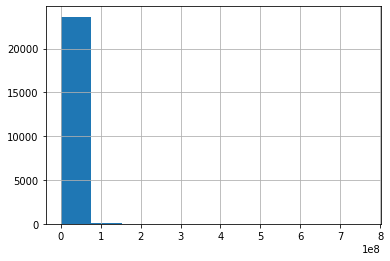

In [7]:
data['last_price'].hist(bins=10)

<AxesSubplot:>

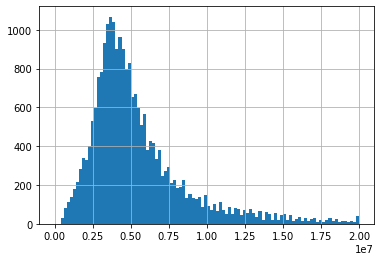

In [8]:
#Посмотрим поближе
data['last_price'].hist(bins=100, range=(0,20000000))

In [9]:
data.query('last_price > 10000000')['last_price'].count()

2721

<AxesSubplot:>

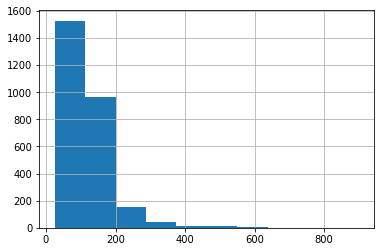

In [10]:
data.query('last_price > 10000000')['total_area'].hist()

Маловероятно что квартиры такого метража могут стоить более 10 млн, хоть таких позиций и большое количество, но скорей всего это ошибки или какие то уникальные предложения и нам придеся их исключить

In [11]:
data = data.query('last_price <= 10000000')

#### Количество комнат
Проанализируем какие значение содержаться в этой колонке

In [12]:
data['rooms'].value_counts()

1    7980
2    7383
3    4662
4     665
0     195
5      83
6       9
7       1
Name: rooms, dtype: int64

Ого, есть квартиры с нулем комнат, может быть это койкоместо в коридоре? 

In [13]:
data[data['rooms'] == 0].describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,195.000000,1.950000e+02,195.000000,195.0,80.00000,192.000000,182.000000,195.000000,0.0,126.000000,116.000000,116.000000,116.000000,28.000000,116.000000,67.000000,181.000000
mean,7.779487,2.924265e+06,27.172872,0.0,3.09850,17.010417,18.636484,8.625641,NaN,1.579365,24488.879310,13517.043103,0.293103,588.928571,0.818966,522.970149,106.922652
std,5.098776,1.043088e+06,6.661562,0.0,2.73239,6.870522,5.788229,6.302377,NaN,0.661552,12491.898351,4974.277652,0.559771,306.655426,0.880703,278.240411,156.489136
min,0.000000,9.457500e+05,15.500000,0.0,2.50000,3.000000,2.000000,1.000000,NaN,0.000000,6989.000000,1261.000000,0.000000,38.000000,0.000000,72.000000,3.000000
25%,4.000000,2.300000e+06,24.025000,0.0,2.70000,12.000000,16.000000,3.000000,NaN,1.000000,14247.000000,11663.000000,0.000000,392.750000,0.000000,342.500000,27.000000
50%,7.000000,2.700000e+06,26.000000,0.0,2.74500,17.000000,18.000000,7.000000,NaN,2.000000,21131.000000,13672.000000,0.000000,532.000000,1.000000,527.000000,49.000000
75%,11.000000,3.362500e+06,28.250000,0.0,2.80000,23.250000,19.875000,13.000000,NaN,2.000000,34201.000000,16481.750000,0.000000,775.750000,1.000000,687.000000,116.000000
max,21.000000,8.200000e+06,73.600000,0.0,27.00000,35.000000,68.000000,26.000000,NaN,2.000000,55551.000000,29846.000000,2.000000,1199.000000,3.000000,1159.000000,931.000000


In [14]:
print('iqr =', 28.4 - 24.05)
# верхняя граница
print('верхняя граница =', 28.4 + (28.4 - 24.05) * 1.5)

iqr = 4.349999999999998
верхняя граница = 34.925



Предположим что квартиры без указания комнат с метражем больше 35 кв. м. это квартиры свободной планировки, в которых нет разделения на комнаты. Их из анализа исключим, так как это уникальные предложения. Остальные квартиры наречем однушками!


In [15]:
data.loc[(data['rooms'] == 0) & (data['total_area'] <= 35), 'rooms'] = 1
data[data['rooms'] == 0]['rooms'].count()


8

In [16]:
# Удалим 10 эксклюзивных квартир
data  = data[data['rooms'] != 0]

Квартиры с более 5 комнатами это либо королевские апартаменты, либо коммунальные квартиры. В обоих случаях это выбросы и мы их исключим.

In [17]:
data = data[data['rooms'] < 6]
data['rooms'].value_counts()

1    8167
2    7383
3    4662
4     665
5      83
Name: rooms, dtype: int64

#### Этажи в доме
У некоторых объявлений не указано количество этажей в доме. Возможно так делают, когда в доме всего один этаж, проверим эту гипотезу.

In [18]:
data[data['floors_total'].isna()]['floor'].value_counts()

4     7
6     7
12    6
8     6
9     5
5     4
7     4
13    3
21    3
19    3
15    3
1     3
11    3
10    3
2     2
14    2
20    2
17    1
18    1
3     1
22    1
24    1
Name: floor, dtype: int64

ВЫВОД: Гипотеза не подтвердилась, возможно просто поленились указать количество этажей в доме. Так как таких объявлений немного, просто будем их убирать при анализе этажности дома.

#### Высота потолков

Первичный анализ

In [19]:
data['ceiling_height'].describe()

count    12639.000000
mean         2.722100
std          1.020731
min          1.000000
25%          2.500000
50%          2.600000
75%          2.750000
max         32.000000
Name: ceiling_height, dtype: float64

In [20]:
#iqr, нижняя и верхняя границы
height_iqr = 2.8-2.52 
print('iqr =', height_iqr)
print('bot =', 2.52 - height_iqr*1.5)
print('top =', 2.8 + height_iqr*1.5)

iqr = 0.2799999999999998
bot = 2.1000000000000005
top = 3.2199999999999998


Убираем выбросы снизу
Нижняя статистически значимой выборки 2.1 м. По СНИПу высота потолков не может быть меньше 2,5 метров. Возможно в эти объявлениях некорректно указаны данные или это помещения каким-то чудом переведены в жилой фонд из нежилого, например подвала. В любом случай это исключения из общей массы и так как их немного, просто удалим все записи с высотой потолков ниже края статистически значимой выборки. Результат обрезки данных будем хранить в новой табличке, по которой потом будем считать медиану. Очень жаль, что в данных нет года постройки дома, по этому показателю точнее всего было бы считать медиану. В таком случае допустим, что у домов с одинаковым количеством этажей не сильно отличающиеся высоты потолков.

In [21]:
#Посмотрим на выбросы 
data.query('ceiling_height < (2.52 - @height_iqr*1.5)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
552,11,2999000.0,33.50,2017-03-30T00:00:00,1,2.00,15.0,17.5,6,NaN,False,False,6.50,NaN,Санкт-Петербург,33972.0,11746.0,1.0,520.0,1.0,949.0,270.0
2572,4,2400000.0,62.00,2018-12-27T00:00:00,3,2.00,5.0,40.0,4,NaN,False,False,6.00,1.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4212,1,2120000.0,35.43,2017-12-18T00:00:00,1,2.00,18.0,16.6,9,NaN,False,False,8.80,2.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0
5712,5,1500000.0,42.80,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,NaN,False,False,5.20,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
5850,9,1650000.0,35.50,2018-05-29T00:00:00,1,2.00,5.0,NaN,5,NaN,False,False,NaN,NaN,Луга,NaN,NaN,NaN,NaN,NaN,NaN,100.0
11352,4,3300000.0,36.00,2017-06-18T00:00:00,1,2.00,17.0,15.2,12,NaN,False,False,10.10,0.0,посёлок Металлострой,25268.0,26980.0,0.0,NaN,0.0,NaN,53.0
16884,0,1500000.0,33.00,2018-10-03T00:00:00,1,2.00,5.0,20.0,5,False,False,False,6.00,NaN,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,6.0
16934,5,4100000.0,40.00,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,NaN,False,False,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
19098,7,2700000.0,56.00,2018-02-04T00:00:00,3,2.00,5.0,46.0,1,NaN,False,False,6.00,NaN,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,282.0
19329,5,1700000.0,40.00,2018-07-15T00:00:00,2,2.00,9.0,NaN,8,NaN,False,False,NaN,NaN,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0


In [22]:
#Обрезаем данные
ceiling_height = data[['ceiling_height','floors_total']]
ceiling_height = ceiling_height.query('ceiling_height > (2.52 - @height_iqr*1.5)')

Теперь работаем с выбросами сверху

In [23]:
#Смотрим выбросы выше верхнего края
ceiling_height.query('ceiling_height > (2.8 + @height_iqr*1.5)')

,ceiling_height,floors_total
135,3.25,5.0
136,3.45,6.0
154,4.15,3.0
235,3.40,3.0
355,25.00,5.0
...,...,...
23430,3.30,5.0
23449,3.25,5.0
23573,3.60,12.0
23664,3.36,7.0


Достаточно много строк, но и потолки до 5 метров в наше время не исключение, посмотрим сколько строк с потолками выше 5 метров

In [24]:
ceiling_height.query('ceiling_height > 5')

,ceiling_height,floors_total
355,25.0,5.0
3148,32.0,3.0
3474,8.0,5.0
4643,25.0,9.0
4876,27.0,25.0
5076,24.0,5.0
5246,27.0,5.0
5669,26.0,9.0
5807,27.0,36.0
5863,8.3,16.0


Уже приемлемое количество. Можно наблюдать в некоторых строка значения, который очень похожи на распространенные значения, но с пропущенным знаком разделения дробной части. Допустим диапазон высот потолков от 2.10 м до 5 м, тогда чтобы исправить ошибку пропущенной запятой, выберем все квартиры с потолками от 21 до 50 и разделим на 10

In [25]:
ceiling_height.loc[(ceiling_height['ceiling_height'] >= 21) & (ceiling_height['ceiling_height'] < 50), 'ceiling_height'] /= 10
ceiling_height.query('ceiling_height > 5')

,ceiling_height,floors_total
3474,8.0,5.0
5863,8.3,16.0
12628,5.3,5.0
15061,14.0,14.0
15743,8.0,16.0
17442,8.0,5.0
17496,20.0,17.0
22309,10.3,16.0


In [26]:
# Остатки посчитаем выбросами и удалим
ceiling_height = ceiling_height.query('ceiling_height < 5')

In [27]:
# Проанализируем медиану и среднюю
ceiling_height = ceiling_height.groupby('floors_total').agg(['median','mean','count'])
ceiling_height.columns = ['median','mean','count']
ceiling_height

,median,mean,count
floors_total,,,
1.0,2.80,2.740000,10
2.0,2.70,2.757801,191
3.0,2.75,2.827970,335
4.0,2.87,2.889135,636
5.0,2.55,2.652998,3315
6.0,3.00,2.960078,383
7.0,2.75,2.812418,244
8.0,2.70,2.722500,136
9.0,2.55,2.570969,2487


Заполняем пропуски.
Медианные значения более похожи на настоящие высоты потолков, поэтому будем заполнять пропуски этими значениями.

In [28]:
for t in data['floors_total'].unique():
    if t in ceiling_height.index:
        data.loc[(data['floors_total'] == t) & (data['ceiling_height'].isna()), 'ceiling_height'] = ceiling_height.loc[t, 'median']
data[data['ceiling_height'].isna()]['floors_total'].value_counts()

33.0    1
Name: floors_total, dtype: int64

In [29]:
# Осталось одна уникальная квартиры без указанной высоты потолков, удалим их
data = data[data['ceiling_height'] > 0]

#### Жилая площадь и площадь кухни
Попытаемся заполнить жилую и кухонную площадь в пропорции к общей площади с категоризацией по количеству комнат

Перед началом работы, уберём выбросы из выборки, чтобы они не оказывали влияение на расчет средний и медианных значений

<AxesSubplot:>

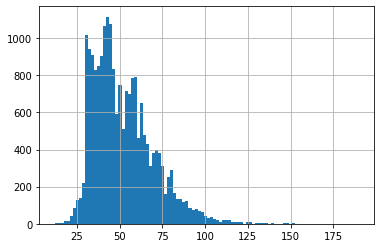

In [30]:
data['total_area'].hist(bins=100)

In [31]:
data.query('total_area > 200')['total_area'].count()

0

In [32]:
data.query('total_area > 150')['total_area'].count()

7

300 строк из 20000 потерять не критично, поэтому исключаем из выброрки все квартиры с общей плозадью более 150 кв. м.

In [33]:
data = data.query('total_area <= 150')

Теперь начинаем расчет пропорций жилой плозади и кухни к общей площади

In [34]:
area_proportion = data[['rooms', 'total_area', 'living_area', 'kitchen_area']].query('living_area > 0 and kitchen_area > 0')
area_proportion['living_area_proportion'] = area_proportion['living_area'] / area_proportion['total_area'] 
area_proportion['kitchen_area_proportion'] = area_proportion['kitchen_area'] / area_proportion['total_area'] 
area_proportion = pd.pivot_table(area_proportion, index="rooms", values=['living_area_proportion', 'kitchen_area_proportion'], aggfunc='mean')
area_proportion.head()

,kitchen_area_proportion,living_area_proportion
rooms,,
1,0.249382,0.481602
2,0.169876,0.585231
3,0.132877,0.641209
4,0.114472,0.677620
5,0.106994,0.658491


Заполняем пропуски

In [35]:
for r in data['rooms'].unique():
    if r in area_proportion.index:
        data.loc[(data['rooms'] == r) & (data['living_area'].isna()), 'living_area'] = round(data['total_area'] * area_proportion.loc[r, 'living_area_proportion'], ndigits=2)
        data.loc[(data['rooms'] == r) & (data['kitchen_area'].isna()), 'kitchen_area'] = round(data['total_area'] * area_proportion.loc[r, 'kitchen_area_proportion'], ndigits=2)
    else:
        print(r)    
print(data[data['living_area'].isna()]['rooms'].value_counts())
print(data[data['kitchen_area'].isna()]['rooms'].value_counts())

Series([], Name: rooms, dtype: int64)
Series([], Name: rooms, dtype: int64)


#### Апартаменты
Флаг того, что данное жилое помещение является "апартаментами". Этот пункт важный, поэтому скорей всего в анкете помещения поставят флаг, если это апартаменты и оставят без внимания, если это квартира. Поэтому все неуказанные значения приравняем к false.

In [36]:
data['is_apartment'] = data['is_apartment'].fillna(False)

### Балконы
Наличие балкона. Если незаполнено, скорей всего балкона нет. Проанализируем значение, которые может принимать этот параметр.

In [37]:
data['balcony'].value_counts()

1.0    3824
2.0    3345
0.0    3312
5.0     222
4.0     123
3.0      60
Name: balcony, dtype: int64

In [38]:
# Тип int64, поэтому незаполненные значение заполним 0
data['balcony'] = data['balcony'].fillna(0)

In [39]:
data['balcony'] = pd.to_numeric(data['balcony'], downcast='integer');
data['balcony'].value_counts()

0    13312
1     3824
2     3345
5      222
4      123
3       60
Name: balcony, dtype: int64

#### Населенный пункт / район / часть города
Начнем с анализа значений

In [40]:
data['locality_name'].value_counts().head(50)

Санкт-Петербург                            13039
посёлок Мурино                               520
посёлок Шушары                               437
Всеволожск                                   393
Колпино                                      336
Пушкин                                       330
посёлок Парголово                            326
Гатчина                                      305
деревня Кудрово                              296
Выборг                                       235
Петергоф                                     193
Красное Село                                 174
Кудрово                                      169
Сестрорецк                                   166
деревня Новое Девяткино                      142
Сертолово                                    141
Ломоносов                                    133
Кириши                                       125
Сланцы                                       112
Волхов                                       111
Кингисепп           

Наблюдаем следующие проблемы:
1. Мусор в виде приставки с типом населенного пункта
2. Чередование `е` и `ё`

Заменим везде `ё` на `е`. Так как объявления по одной области, то дубли названий населенных пунктов маловероятны и от типа населенного пункта можно избавиться.

In [41]:
data['locality_name_clear'] = data['locality_name'].str.replace('ё', 'е')

In [42]:
# теперь посмотри какие есть приставки
data.locality_name_clear.str.extract(r'(^.* )').value_counts()


поселок                                              2033
деревня                                               735
поселок городского типа                               295
Красное                                               174
городской поселок                                     170
деревня Новое                                         142
Сосновый                                               86
поселок городского типа имени                          53
село                                                   30
поселок Новый                                          28
Лодейное                                               20
деревня Малое                                          20
деревня Большие                                        16
городской поселок Большая                              16
Новая                                                  14
поселок станции                                        13
поселок городского типа Красный                         8
деревня Малые 

Удалим самое распространенное и попробуем ещё раз

In [43]:
data['locality_name_clear'] = data['locality_name_clear'].str.replace('поселок городского типа ', '')
data['locality_name_clear'] = data['locality_name_clear'].str.replace('городской поселок ', '')
data['locality_name_clear'] = data['locality_name_clear'].str.replace('коттеджный поселок ', '')
data['locality_name_clear'] = data['locality_name_clear'].str.replace('поселок ', '')
data['locality_name_clear'] = data['locality_name_clear'].str.replace('деревня ', '')
data['locality_name_clear'] = data['locality_name_clear'].str.replace('село ', '')

data.locality_name_clear.str.extract(r'(^.* )').value_counts()

Красное                                              174
Новое                                                142
Сосновый                                              86
имени                                                 53
Новый                                                 28
Большая                                               22
Малое                                                 20
Лодейное                                              20
Большие                                               16
Новая                                                 14
станции                                               13
Старая                                                 8
Красный                                                8
Малые                                                  7
Дружная                                                5
садовое товарищество                                   3
Лисий                                                  3
Красная                        

Основные населенные пункты нормализовали, остались единичные случаи, обрабатывать их не будем

#### Срок размещения объявления
Как обычно, начнем с анализа содержимого

In [44]:
print(data['days_exposition'].isna().sum())
print(data['days_exposition'].describe())

2493
count    18393.000000
mean       170.844397
std        208.265516
min          1.000000
25%         43.000000
50%         91.000000
75%        217.000000
max       1580.000000
Name: days_exposition, dtype: float64


3000 объявлений это ~15% от общего числа, достаточно большой процент, чтобы просто так с ними расстаться. Какие могут быть варианты? Нет возможности узнать, была ли продана квартира, поэтому нельзя отличить продали квартиру в тот же день или просто ошиблись в объявлении и сняли его с публикации. Давайте посмотрим, сколько квартир продалось за 1 день.

In [45]:
print(data[data['days_exposition'] == 1]['days_exposition'].count())

1


Всего одна квартира! Делаю вывод, что объявления с незаполненным сроком экспозиции ошибочные и без сожаления их удалим

In [46]:
data = data[data['days_exposition'] > 0]

#### Дата публикации объявления
Для последующего анализа преобразуем дату из строки в datetime

In [47]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

#### Картографические данные
Я бы попросил сотрудников отдела яндекс.карты дополнить данные, но сейчас у меня такой возможности нет, поэтому просто оставим пропуски как есть. При анализе картографических данных будем в моменте исключать пустые значения.

#### ЗАКЛЮЧЕНИЕ
1. Объявления без указания этажности дома, я оставил. Если потребуется анализ этого параметра, исключим перед анализом
2. Высоту потолков заполнили медианным значением по этажности дома.
3. Жилую и кухонную площади заполнили в медианной попрорции к общей площади по данным квартир с таким же количеством комнат.
4. Признак апартаментов установили в ложь везде, где не был заполнен.
5. Количество балконов указали в 0, везде где не было заполнено.
6. Наименование населенного пункта нормализовали: удалили лишнее, заменили ё на е
7. Объявления с незаполненным сроком экспозиции удалили.
8. Дату публикации преобразовали в datetime64
9. Картографические данные оставили без изменений

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18393 entries, 1 to 23695
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          18393 non-null  int64         
 1   last_price            18393 non-null  float64       
 2   total_area            18393 non-null  float64       
 3   first_day_exposition  18393 non-null  datetime64[ns]
 4   rooms                 18393 non-null  int64         
 5   ceiling_height        18393 non-null  float64       
 6   floors_total          18389 non-null  float64       
 7   living_area           18393 non-null  float64       
 8   floor                 18393 non-null  int64         
 9   is_apartment          18393 non-null  bool          
 10  studio                18393 non-null  bool          
 11  open_plan             18393 non-null  bool          
 12  kitchen_area          18393 non-null  float64       
 13  balcony         

Из 23699 объявлений осталось 20437, потери данных невелики.

### Посчитайте и добавьте в таблицу новые столбцы

In [49]:
# Цена одного квадратного метра
data['price_of_sqm'] = data['last_price'] / data['total_area']
# день недели публикации объявления
data['exposition_dow'] = data['first_day_exposition'].dt.day_of_week
# месяц публикации объявления
data['exposition_month'] = data['first_day_exposition'].dt.month
# год публикации объявления
data['exposition_year'] = data['first_day_exposition'].dt.year

In [50]:
# тип этажа квартиры (значения — «первый», «последний», «другой»);
def floor_type(floor, floors_total):
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

data['floor_type'] = data.apply(lambda x: floor_type(x['floor'], x['floors_total']), axis=1)    

In [51]:
# расстояние до центра города в километрах
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)


In [52]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_clear,price_of_sqm,exposition_dow,exposition_month,exposition_year,floor_type,cityCenters_nearest_km
1,7,3350000.0,40.4,2018-12-04,1,2.73,11.0,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,Шушары,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.55,5.0,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,Санкт-Петербург,92785.714286,3,8,2015,другой,14.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,Санкт-Петербург,100000.000000,1,6,2018,другой,8.0
5,10,2890000.0,30.4,2018-09-10,1,2.65,12.0,14.4,5,False,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,Янино-1,95065.789474,0,9,2018,другой,NaN
6,6,3700000.0,37.3,2017-11-02,1,2.65,26.0,10.6,6,False,False,False,14.4,1,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,Парголово,99195.710456,3,11,2017,другой,19.0


### Проведите исследовательский анализ данных

#### Общая площадь

In [53]:

data['total_area'].describe()

count    18393.000000
mean        51.614004
std         17.458483
min         12.000000
25%         38.130000
50%         47.500000
75%         61.760000
max        147.800000
Name: total_area, dtype: float64

Межквартильное расстояние: 28.25
В рамки среднестатистического распределения попадает 18282 объявлений


<AxesSubplot:>

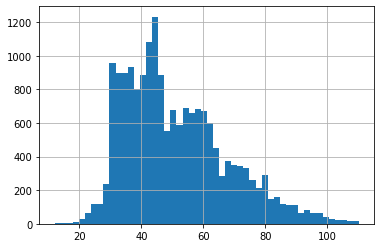

In [54]:
iqr = 67.8-39.55
q_min = 12 #минимум меньше чем нижняя граница статистически значимой выборки
q_max = 67.8 + iqr*1.5 #200 #взял с запасом верхнюю границу
qty = data.query('total_area > @q_min and total_area < @q_max')['total_area'].count()
print(f'Межквартильное расстояние: {iqr}')
print(f'В рамки среднестатистического распределения попадает {qty} объявлений')
data['total_area'].hist(range=(q_min, q_max), bins=50)

Пик площадей продаваемых квартир находится в границе 40-50 квадратных метров

#### Жилая площадь

<AxesSubplot:>

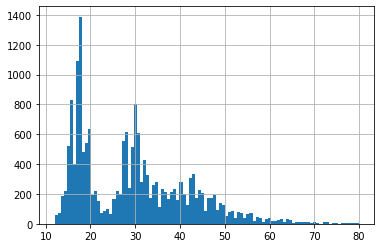

In [55]:
data['living_area'].hist(range=(q_min,80), bins=100)

Пик наблюдаем с 15 до 20, второй с 27 до 32, я думаю это соответствует метражу однокомнатных и двухкомнатных квартир соответственно. 

#### Площадь кухни

<AxesSubplot:>

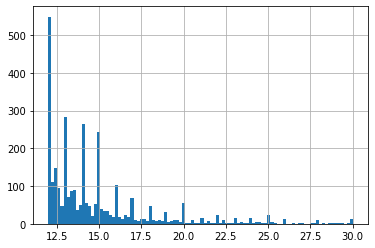

In [56]:
data['kitchen_area'].hist(range=(q_min,30), bins=100)

Ожидаемо, предложений с маленькими кухнями больше всего. Пики на графике отражают квартиры типовой планировки.

#### Цена объекта

In [57]:
print(data['last_price'].describe())

count    1.839300e+04
mean     4.599748e+06
std      1.922684e+06
min      1.219000e+04
25%      3.290000e+06
50%      4.290000e+06
75%      5.700000e+06
max      1.000000e+07
Name: last_price, dtype: float64


<AxesSubplot:>

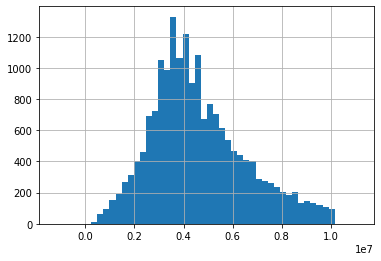

In [58]:
iqr = 6500000 - 3400000
q_min = 3400000 - iqr * 1.5
q_max = 6500000 + iqr * 1.5
data['last_price'].hist(range=(q_min,q_max), bins=50)

Большинство квартир стоят от 2 до 6 миллионов рублей.

#### Количество комнат


<AxesSubplot:xlabel='rooms'>

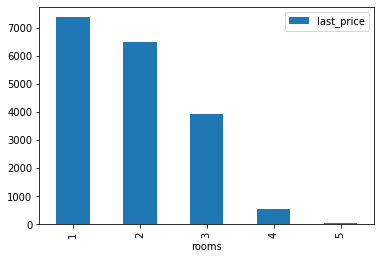

In [59]:
room_data = data.pivot_table(index="rooms", values='last_price', aggfunc="count")
room_data.plot.bar()

Однушек больше всего, двушек чуть меньше, трешек ещё меньше, а 4-5 комнатные скорее исключение

#### Высота потолков

<AxesSubplot:>

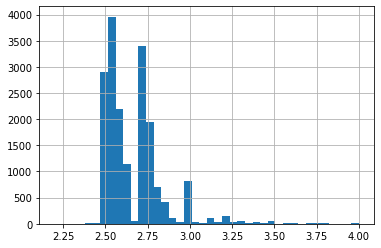

In [60]:
data['ceiling_height'].hist(range=(2.2, 4), bins=40)

In [61]:
data['ceiling_height'].value_counts()

2.55    3760
2.70    3280
2.50    2862
2.60    1913
2.75    1588
        ... 
4.15       1
3.78       1
3.37       1
3.42       1
3.46       1
Name: ceiling_height, Length: 148, dtype: int64

Пики на 2.50-2.55 и 2.70-2.75 - высота типовых квартир

#### Этажи

<AxesSubplot:>

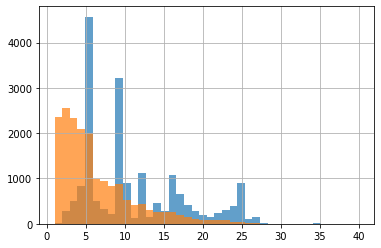

In [62]:

ax = data['floors_total'].hist(range=(1,40), bins=40, alpha=0.7)
data['floor'].hist(range=(1,40), bins=40, ax=ax, alpha=0.7)

<AxesSubplot:ylabel='floor_type'>

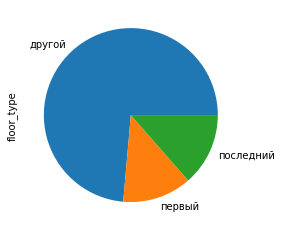

In [63]:
floor_type = data.groupby('floor_type')['floor_type'].count()
floor_type.plot.pie()

Больше всего пятиэтажек и девятиэтажек, соответственно самые частый этажи до 5 и до 9. Примерно 8 часть предложений приходится на первый и на последние этаже.

#### Расстояние до ближайших объектов

In [64]:
data['cityCenters_nearest'].describe()

count    13768.000000
mean     15179.382554
std       8486.197070
min        208.000000
25%      10858.750000
50%      13754.500000
75%      16802.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

<AxesSubplot:>

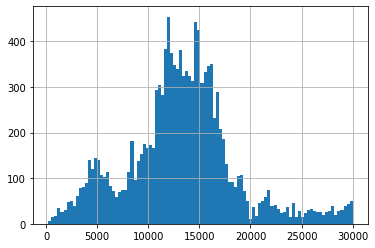

In [65]:
data['cityCenters_nearest'].hist(range=(208,30000), bins=100)

<AxesSubplot:>

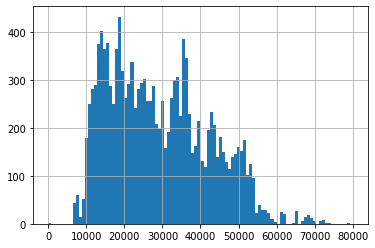

In [66]:
data['airports_nearest'].hist(range=(0,80000), bins=100)

<AxesSubplot:>

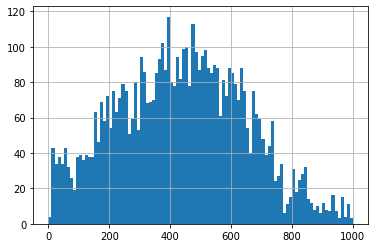

In [67]:
data['parks_nearest'].hist(range=(0,1000), bins=100)

В большинстве центр город находится в на расстоянии от 11 до 17 км, аэропорт от 10 до 55 км, а до парка от 300до 550 метров.

#### Дата публикации

<AxesSubplot:xlabel='exposition_dow'>

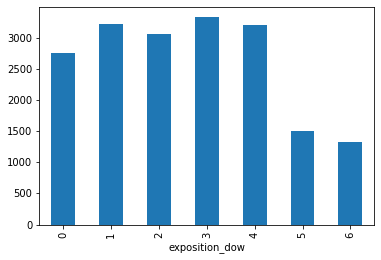

In [68]:
data_dow = data.groupby('exposition_dow')['exposition_dow'].count()
data_dow.plot.bar()

<AxesSubplot:xlabel='exposition_month'>

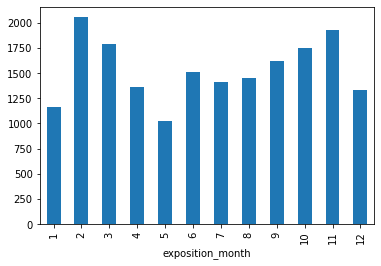

In [69]:
data_dow = data.groupby('exposition_month')['exposition_dow'].count()
data_dow.plot.bar()

Чаще всего объявления публикуют в рабочие дни, предположу что это связано с тем, что большая часть публикуется сотрудниками риэлторских организаций, которые работают по графику 5/2
По месяцам можно наблюдать некоторую "сезонность" с пиками в феврале и в ноябре.

#### Срок продажи

In [70]:
data['days_exposition'].describe()

count    18393.000000
mean       170.844397
std        208.265516
min          1.000000
25%         43.000000
50%         91.000000
75%        217.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

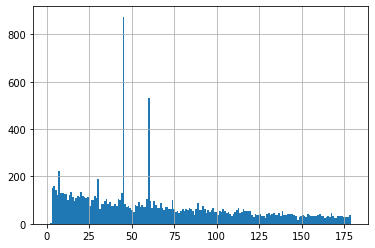

In [71]:
data['days_exposition'].hist(range=(1,180), bins=180)

Медианный срок продаже ~3 месяца, если удалось продать квартиру менее  чем за 45 дней, то это можно считать быстрой продажей. Среднее арифметическое время продаж - полгода, но возможно это число завышено из-за старых объявлений, про который забыли которые висят несколько лет.

### Факторы влияющие на стоимость квартиры

In [72]:
area_data = data.query('kitchen_area < 30')[['last_price','total_area','living_area', 'kitchen_area', 'rooms', 'floor_type']]

corr = area_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,last_price,total_area,living_area,kitchen_area,rooms
last_price,1.000000,0.673390,0.556311,0.464146,0.436451
total_area,0.673390,1.000000,0.917722,0.417566,0.807624
living_area,0.556311,0.917722,1.000000,0.142396,0.897707
kitchen_area,0.464146,0.417566,0.142396,1.000000,0.015535
rooms,0.436451,0.807624,0.897707,0.015535,1.000000


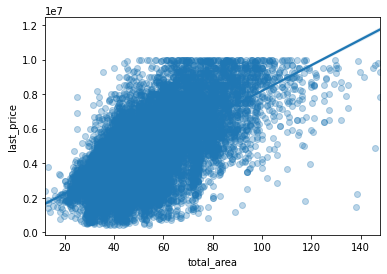

In [73]:
sb.regplot(x=area_data["total_area"], y=area_data["last_price"], scatter_kws={'alpha':0.3});

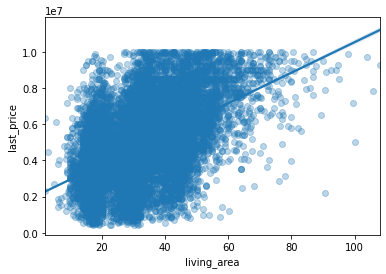

In [74]:
sb.regplot(x=area_data["living_area"], y=area_data["last_price"], scatter_kws={'alpha':0.3});

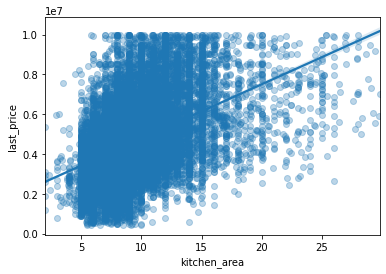

In [75]:
sb.regplot(x=area_data["kitchen_area"], y=area_data["last_price"], scatter_kws={'alpha':0.3});

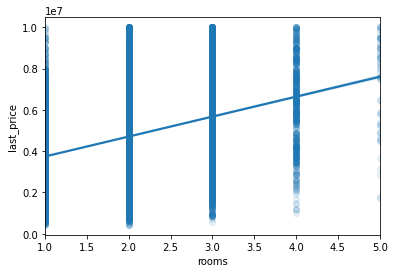

In [76]:
sb.regplot(x=area_data["rooms"], y=area_data["last_price"], scatter_kws={'alpha':0.1});

In [77]:
## чтобы понять, если ли зависимость от типа этажа, сделаем выборку только по однокомнатным
area_data.query('rooms == 1').groupby('floor_type')['last_price'].median()

floor_type
другой       3642500.0
первый       3000000.0
последний    3200000.0
Name: last_price, dtype: float64

In [78]:
expo_data = data.query('rooms == 1')[['last_price','exposition_year','exposition_month', 'exposition_dow']]

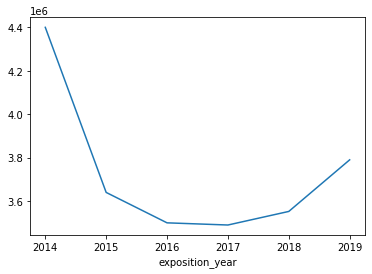

In [79]:
expo_data.groupby('exposition_year')['last_price'].median().plot.line();

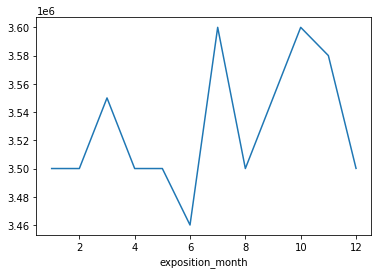

In [80]:
expo_data.groupby('exposition_month')['last_price'].median().plot.line();

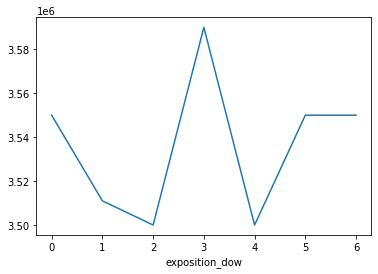

In [81]:
expo_data.groupby('exposition_dow')['last_price'].median().plot.line();

**Основной фактор, влияющий на цену - общая площадь.** В какой то мере на цену влияет так же тип этажа, зависимость от количества комнат, жилой площади и кухни незначительная, эти параметры тоже в своею очередь зависят от общей площади. 
<br>Наибольшая медианная цена была зафиксирована в 2014, потом в был спад, с минимумов в 2016-2017. После чего снова начался рост стоимости жилья. 
<br>Во второй половине года стоимость предложений увеличивается в среднем на 3%. 
<br>Стоимость в объявлениях публикуемых в четверг примерно на 2% выше, чем у объявлений публикумеых в среду и пятницу. 

#### Средняя цена одного квадратного метра в 10 населённых пунктах  

In [82]:
top_locality = data['locality_name_clear'].value_counts().head(10)

In [83]:
(
    data.query('locality_name_clear in @top_locality.index')
    .groupby('locality_name_clear')['price_of_sqm']
    .mean()
    .sort_values(ascending=False)
)    

locality_name_clear
Санкт-Петербург    103333.429812
Пушкин              99281.872425
Кудрово             94343.881725
Парголово           89672.150523
Мурино              85691.011789
Шушары              77980.383629
Колпино             74599.167217
Гатчина             67845.395923
Всеволожск          66724.848596
Выборг              57084.582948
Name: price_of_sqm, dtype: float64

Стоимость жилья в самом Санкт-Петербурге выше чем в городах спутниках, иногда до 200%. Пушкин, Кудрово и Парговолов являются следующими по средней стоимости квадратного метра.

#### Стоимость километра

In [84]:
(
    data.query('locality_name_clear == "Санкт-Петербург"')
    .groupby('cityCenters_nearest_km')['price_of_sqm']
    .mean()
    .sort_values(ascending=False)
)    

cityCenters_nearest_km
6.0     118937.901286
5.0     118275.521575
1.0     116419.137930
7.0     113124.442775
8.0     112921.818172
4.0     112429.658445
0.0     111429.755790
2.0     111080.427042
10.0    106301.920725
3.0     105159.571821
12.0    104342.038313
9.0     104161.112576
13.0    104118.008386
14.0    102089.406514
11.0    102059.206536
20.0    101029.383819
15.0    100567.530965
16.0     97794.523236
19.0     97546.465795
18.0     94601.573092
17.0     94206.288473
25.0     91531.371618
21.0     90528.836532
23.0     89830.244101
22.0     89416.712813
26.0     87832.108756
24.0     85736.904595
28.0     81161.915320
29.0     76238.677228
27.0     70312.500000
Name: price_of_sqm, dtype: float64

Чем дальше от центра - тем дешевле, из общего ряда выбивается только 27 километр. Возможно на этом расстоянии от центра города расположен элитный жилой массив.

### Общий вывод

В основном жилой фонд представлен квартирами в пяти и девяти этажных домах, с парком в радиусе 700 метров, в 10-15 км от центра города и до 50 км до ближайшего аэропорта. 

*Наибольшей влияние на стоимость квартиры имеют общий метраж помещения, удаленность от центра города, расположение  и общая экономическая ситуация в стране.* Второстепенное влияние на цену имеют тип этажа. Чтобы выручить больше денег от продажи публиковать объявление лучше в феврале или ноябре, тогда цены на жилье достигают пиковых значений. 
<br>Во второй половине года стоимость предложений увеличивается в среднем на 3%. 
<br>Стоимость в объявлениях публикуемых в четверг примерно на 2% выше, чем у объявлений публикумеых в среду и пятницу. 

При продаже по рыночной цене в ликвидном районе, средний срок продажи составляет от 25 до 90 дней. Если вариант какой-то особенный, то продажа может затянуться от полугода до года.

Наиболее варианты это квартиры из 1-2 комнаты, площадью до 50 кв. м. , ценой от 3 до 5 млн и распложенные в населенных пунктах Санкт-Петербург, Пушкин, Кудрово, Парголово


